In [6]:
import sys
import os

gene_symbol_set = set()

with open( '../data/gene_id_names.txt' ) as infile:
    for line in infile:
        geneid = line.strip().split( '\t' )[0]
        genesymbol = line.strip().split( '\t' )[-2]
        genesymbol = genesymbol.strip().strip( '"' ).strip()
        if genesymbol == '':
            continue
        gene_symbol_set.add( genesymbol )
print( len( gene_symbol_set ) )


with open( '../resource/gencode.v19.annotation.gff3' ) as infile, \
        open( '../result/gene_annotation.bed', 'w' ) as outfile:
    for line in infile:
        if line.find( '\tCDS\t' ) < 0:
            # ignore non-cds entries;
            continue
            
        line = line.strip().split( '\t' )
        chromosome = line[0].replace( 'chr', '' )
        start = line[3]
        end = line[4]
        attrs = line[-1]
        for attr in attrs.split( ';' ):
            k, v = attr.split( '=' )
            if k == 'gene_name':
                symbol = v
                if symbol in gene_symbol_set:
                    outfile.write( chromosome + '\t' + start + '\t' + end + '\t' + attr + '\n' )
    
with open( '../resource/ALL.wgs.integrated_phase1_v3.20101123.snps_indels_sv.sites.vcf' ) as infile, \
        open( '../result/gene_varient.bed', 'w' ) as outfile:
    for line in infile:
        if( line.startswith( '#' ) ):
            continue
        line = line.strip().split( '\t' )
        chromosome = line[0]
        start = str(int(line[1])-1)
        end = line[1]
        attrs = line[-1]

        for attr in attrs.split( ';' ):
            k, v = attr.split( '=' )
            if k == 'VT':
                outfile.write( chromosome + '\t' + start + '\t' + end + '\t' + attr + '\n' )
    


20359


In [7]:
!intersectBed -wo -a gene_annotation.bed -b gene_varient.bed > gene_overlap.txt

/bin/sh: 1: intersectBed: not found


In [16]:
import sys
import os
import numpy as np

gene_varients = {}
with open( '../result/gene_overlap.txt' ) as infile:
    for line in infile:
        line = line.strip().split( '\t' )
        symbol = line[3].split('=')[-1]
        varient = line[-2].split('=')[-1]
        gene_varients.setdefault( symbol, {} )
        gene_varients[ symbol ].setdefault( varient, 0 )
        gene_varients[ symbol ][ varient ] += 1

print( len( gene_varients ) )


16952


In [18]:
import sys
import os
import numpy as np

group_varients = {}

with open( "../result/gene_mean_pvalues.txt" ) as infile:
    for line in infile:
        line = line.strip().split( '\t' )
        symbol = line[1].strip('"')
        pvalue = float( line[2] )
        vdiff = float( line[5])
        
        if pvalue < 0.05:
            if vdiff >= 0:
                group = "group1"
            else:
                group = "group2"
        else:
            group = "group3"
            
        group_varients.setdefault( group, {} )
        if symbol in gene_varients:
            group_varients[ group ].setdefault( symbol, {} )
            group_varients[ group ][ symbol ] = gene_varients[ symbol ]

        
def get_numbers( group_varients, varient ):
    ret = {}
    for k, v in group_varients.items():
        for k2, v2 in v.items():
            for k3, v3 in v2.items():
                if k3 == varient:
                    ret.setdefault( k, [] )
                    ret[ k ].append( v3 )

    return ret


ttest_ind:            t = 5.48796  p = 4.12721e-08
The difference are significant.
ttest_ind:            t = 0.133463  p = 0.893829
The difference are significant.


/opt/conda/lib/python3.6/site-packages/matplotlib/figure.py:403: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


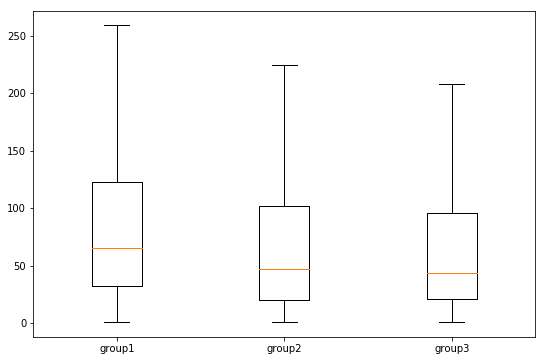

In [36]:
import matplotlib as mpl
import matplotlib.pyplot as plt
from scipy.stats import ttest_ind, ttest_ind_from_stats

ret = get_numbers( group_varients, 'SNP' )

t, p = ttest_ind(ret['group1'], ret['group3'], equal_var=False)
print("ttest_ind:            t = %g  p = %g" % (t, p))
print("The difference are significant." )
t, p = ttest_ind(ret['group2'], ret['group3'], equal_var=False)
print("ttest_ind:            t = %g  p = %g" % (t, p))
print("The difference are significant." )


data_to_plot = [ ret['group1'], ret['group2'], ret['group3'] ]
fig = plt.figure(1, figsize=(9, 6))

# Create an axes instance
ax = fig.add_subplot(111)

# Create the boxplot
ax.boxplot(data_to_plot, showfliers=False) # too much outliers, ignore them for now.
ax.set_xticklabels(['group1', 'group2', 'group3'])
fig.show()


ttest_ind:            t = 1.98571  p = 0.0475067
The difference are significant.
ttest_ind:            t = -0.219041  p = 0.826661
The difference are significant.


/opt/conda/lib/python3.6/site-packages/matplotlib/figure.py:403: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


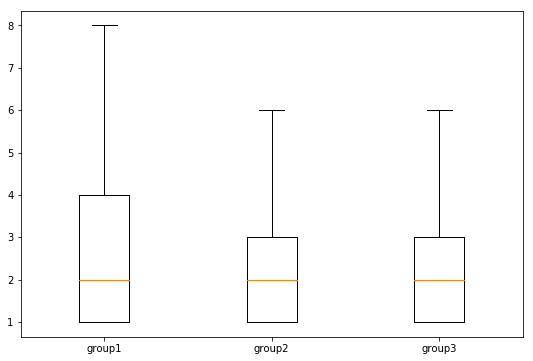

In [39]:
import matplotlib as mpl
import matplotlib.pyplot as plt

ret = get_numbers( group_varients, 'INDEL' )
t, p = ttest_ind(ret['group1'], ret['group3'], equal_var=False)
print("ttest_ind:            t = %g  p = %g" % (t, p))
print("The difference are significant." )
t, p = ttest_ind(ret['group2'], ret['group3'], equal_var=False)
print("ttest_ind:            t = %g  p = %g" % (t, p))
print("The difference are significant." )


data_to_plot = [ ret['group1'], ret['group2'], ret['group3'] ]
fig = plt.figure(1, figsize=(9, 6))

# Create an axes instance
ax = fig.add_subplot(111)

# Create the boxplot
ax.boxplot(data_to_plot, showfliers=False) # too much outliers, ignore them for now.
ax.set_xticklabels(['group1', 'group2', 'group3'])
fig.show()

ttest_ind:            t = 1.57349  p = 0.137612
The difference are significant.
ttest_ind:            t = 0.828343  p = 0.411736
The difference are significant.


/opt/conda/lib/python3.6/site-packages/matplotlib/figure.py:403: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


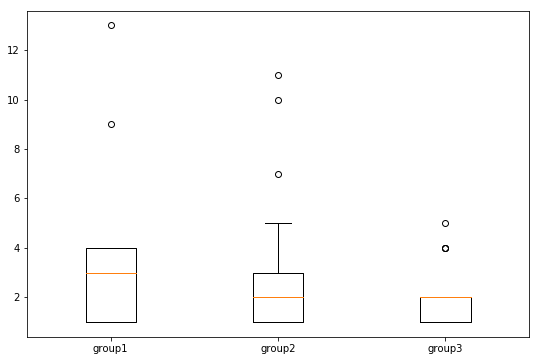

In [38]:
import matplotlib as mpl
import matplotlib.pyplot as plt

ret = get_numbers( group_varients, 'SV' )

t, p = ttest_ind(ret['group1'], ret['group3'], equal_var=False)
print("ttest_ind:            t = %g  p = %g" % (t, p))
print("The difference are significant." )
t, p = ttest_ind(ret['group2'], ret['group3'], equal_var=False)
print("ttest_ind:            t = %g  p = %g" % (t, p))
print("The difference are significant." )


data_to_plot = [ ret['group1'], ret['group2'], ret['group3'] ]
fig = plt.figure(1, figsize=(9, 6))

# Create an axes instance
ax = fig.add_subplot(111)

# Create the boxplot
ax.boxplot(data_to_plot) # too much outliers, ignore them for now.
ax.set_xticklabels(['group1', 'group2', 'group3'])
fig.show()